# 流程
1. 读取数据
2. 打点：绿买点，红卖点
3. 每日数据处理为散点
4. 合并总训练集

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

stock_code = '600887'
column_list = ['price','change','volume','amount','type']

source_dir = 'D:/share_data/' + stock_code + '/0.source/daily/'
plot_dir = 'D:/share_data/' + stock_code + '/1.plot/daily/'
instance_dir = 'D:/share_data/' + stock_code + '/2.instance/daily/'
predict_dir = 'D:/share_data/' + stock_code + '/3.predict/daily/'
match_dir = 'D:/share_data/' + stock_code + '/4.match/daily/'

sell_windows_size = 50
buy_windows_size = 50
instance_windows_size = 60

sell_outlier_rate = 1.4
sell_total_outlier_rate = 0
buy_outlier_rate = 1.2
buy_total_outlier_rate = 0


#计算所有卖点
def get_sell_points(daily_data,windows_size,outlier_rate,total_outlier_rate):
    result = []
    total_mean = np.mean(daily_data.price)
    total_std = np.std(daily_data.price)
    for idx in range(windows_size,daily_data.shape[0]-windows_size,1):
        #if daily_data.price[idx] < total_mean + total_outlier_rate * total_std:
        #    continue
        pre_mean = np.mean(daily_data.price[(idx-windows_size):idx])
        pre_std = np.std(daily_data.price[(idx-windows_size):idx])
        post_mean = np.mean(daily_data.price[(idx+1):(idx+windows_size)])
        post_std = np.std(daily_data.price[(idx+1):(idx+windows_size)])
        if (daily_data.price[idx] > pre_mean + outlier_rate * pre_std) and (daily_data.price[idx] > post_mean + outlier_rate * post_std):
            result.append(idx)
                
    return result

#计算所有买点
def get_buy_points(daily_data,windows_size,outlier_rate,total_outlier_rate):
    result = []
    total_mean = np.mean(daily_data.price)
    total_std = np.std(daily_data.price)
    for idx in range(windows_size,daily_data.shape[0]-windows_size,1):
        #if daily_data.price[idx] > total_mean - total_outlier_rate * total_std:
        #    continue
        pre_mean = np.mean(daily_data.price[(idx-windows_size):idx])
        pre_std = np.std(daily_data.price[(idx-windows_size):idx])
        post_mean = np.mean(daily_data.price[(idx+1):(idx+windows_size)])
        post_std = np.std(daily_data.price[(idx+1):(idx+windows_size)])
        if total_std > (pre_std + post_std) * 3:
            continue
        if (daily_data.price[idx] < pre_mean - outlier_rate * pre_std) and (daily_data.price[idx] < post_mean - outlier_rate * post_std):
            result.append(idx)
    
    return result

#绘图
def plot_points(daily_data,sell_points,buy_points,file_name):
    plt.figure(figsize=(12, 6))
    plt.plot(range(daily_data.shape[0]),daily_data.price)
    plt.plot(sell_points,daily_data.price[sell_points],'ro')
    plt.plot(buy_points,daily_data.price[buy_points],'yo')
    plt.savefig(plot_dir + file_name + '.png')

#获取实例
def get_instances(daily_data,windows_size,sell_points,buy_points):    
    feature_data = daily_data
    feature_data['change_rate'] = daily_data.change/(daily_data.price - daily_data.change)
    feature_data['str_type'] = 0
    feature_data.str_type[daily_data.type == '买盘'] = 1
    feature_data.str_type[daily_data.type == '卖盘'] = -1
    feature_data = feature_data.drop(columns=['type'])
    
    #组建特征
    result = feature_data.iloc[0:(daily_data.shape[0]-windows_size)]
    for idx in range(1,windows_size,1):
        tmp = feature_data.iloc[idx:(daily_data.shape[0]-windows_size+1)].reset_index(drop=True)
        result = pd.concat([result,tmp],axis=1)
    
    col_name = ['col_' + str(i) for i in range(result.shape[1])]
    result.columns = col_name
    
    #添加时间标签
    result['time_idx'] = result.index + windows_size
    
    #添加标签
    label_list = []
    for idx in range(result.shape[0]):
        tmp_idx = idx + windows_size
        if tmp_idx in buy_points:
            label_list.append(1)
        elif tmp_idx in sell_points:
            label_list.append(-1)
        else:
            label_list.append(0)
    result['label'] = pd.Series(data=label_list)
    
    return result

#写入实例
def output_instances(instance_data,file_name):
    instance_data.to_csv(instance_dir + file_name,index=None)

total 23 files.
current file 1: 600887_20190620.csv
current file 2: 600887_20190626.csv
current file 3: 600887_20190627.csv
current file 4: 600887_20190628.csv
current file 5: 600887_20190701.csv
current file 6: 600887_20190702.csv
current file 7: 600887_20190703.csv
current file 8: 600887_20190704.csv
current file 9: 600887_20190705.csv
current file 10: 600887_20190708.csv
current file 11: 600887_20190709.csv
current file 12: 600887_20190710.csv
current file 13: 600887_20190711.csv
current file 14: 600887_20190712.csv
current file 15: 600887_20190715.csv
current file 16: 600887_20190814.csv
current file 17: 600887_20190819.csv
current file 18: 600887_20190911.csv
current file 19: 600887_20190916.csv
current file 20: 600887_20190920.csv
current file 21: 600887_20190925.csv
current file 22: 600887_20200203.csv
current file 23: 600887_20200204.csv


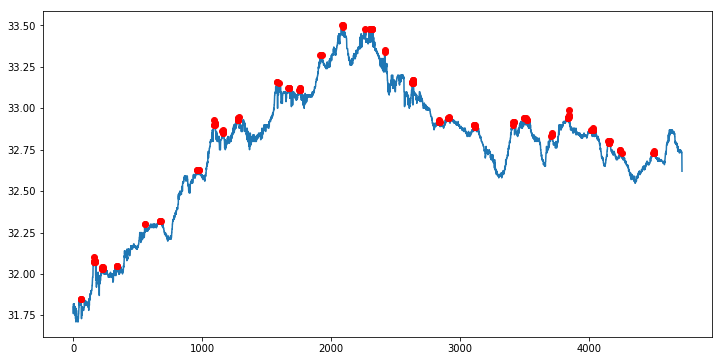

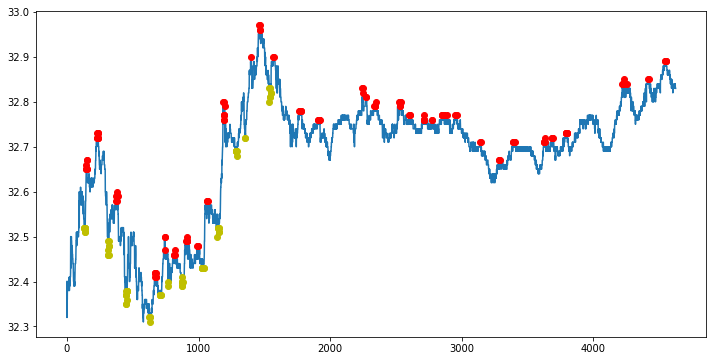

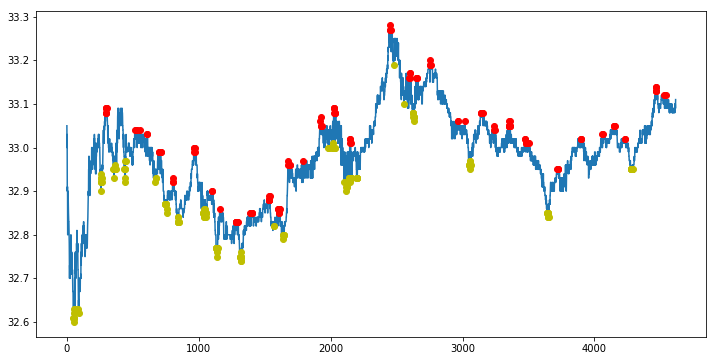

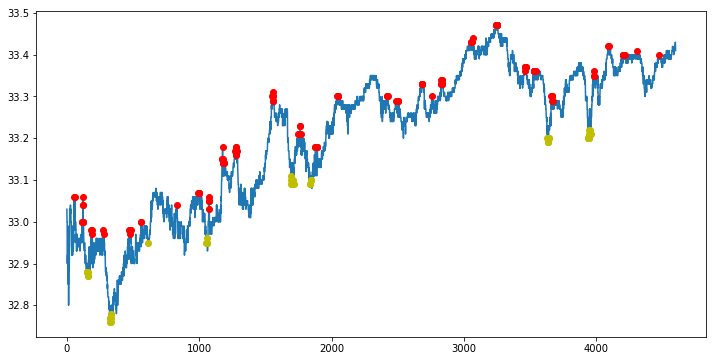

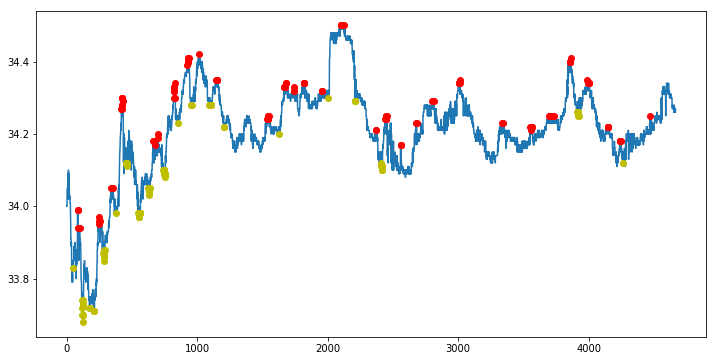

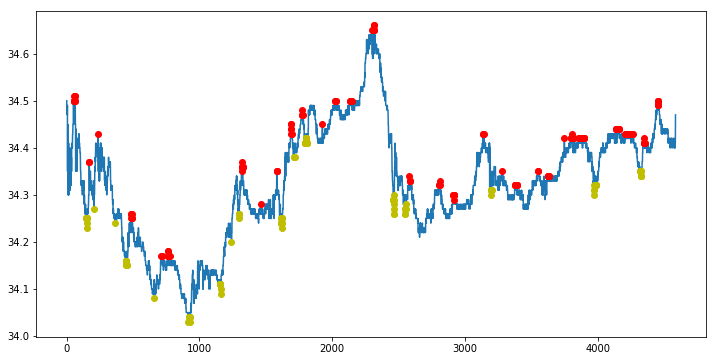

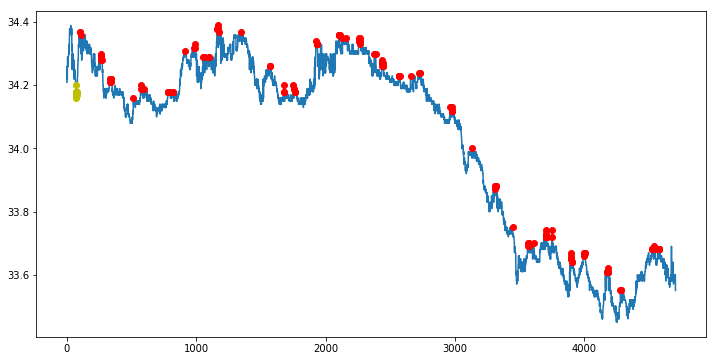

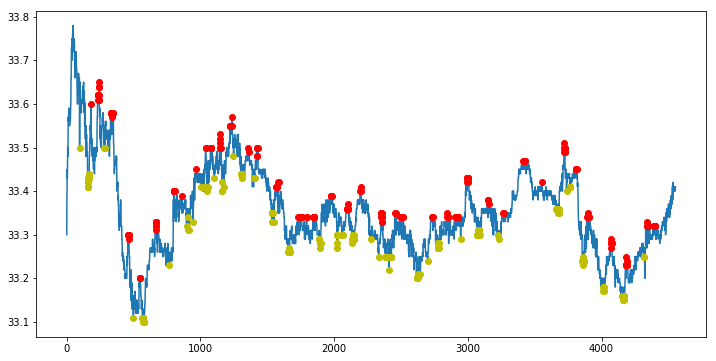

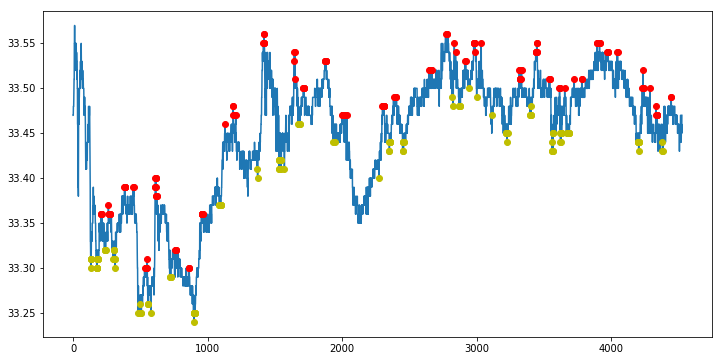

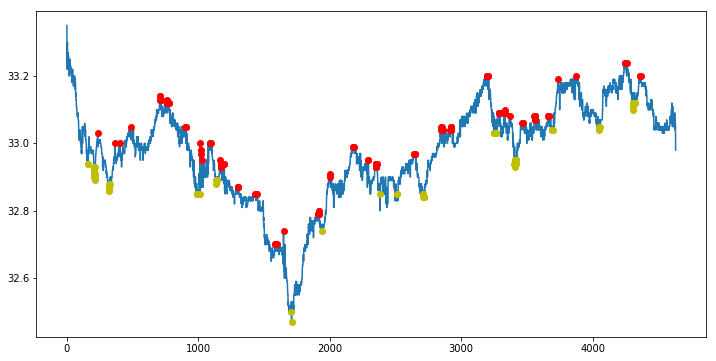

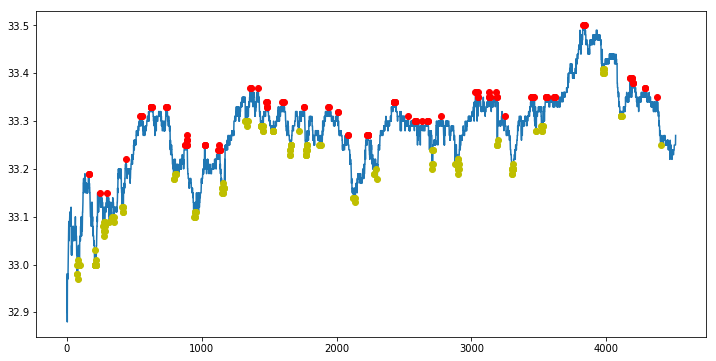

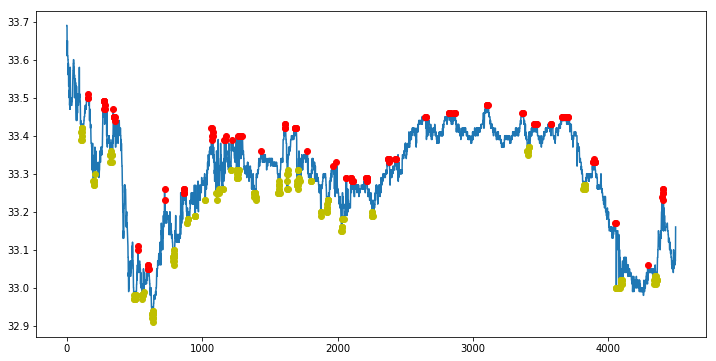

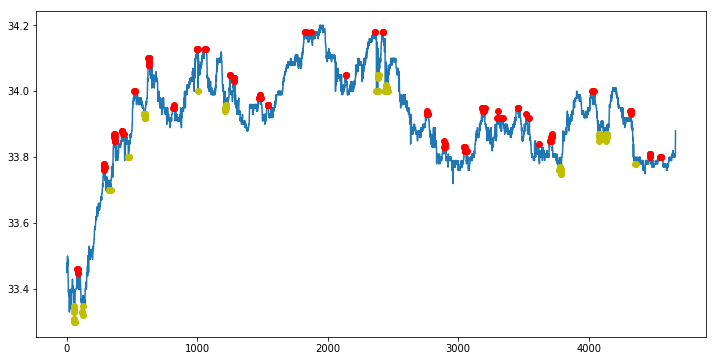

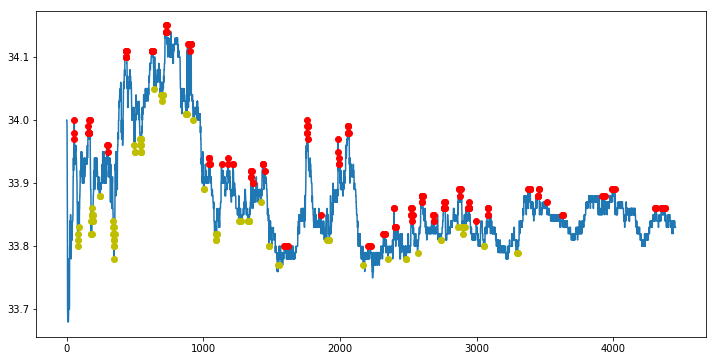

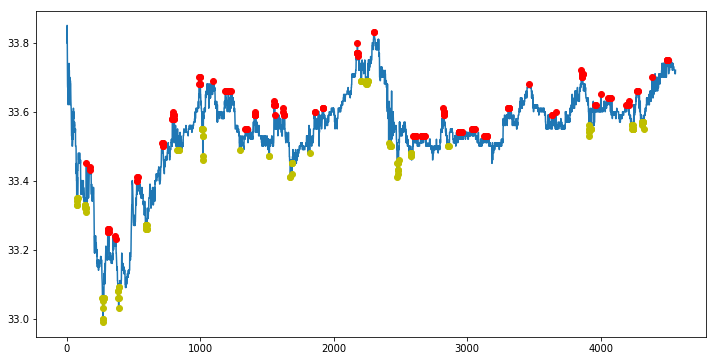

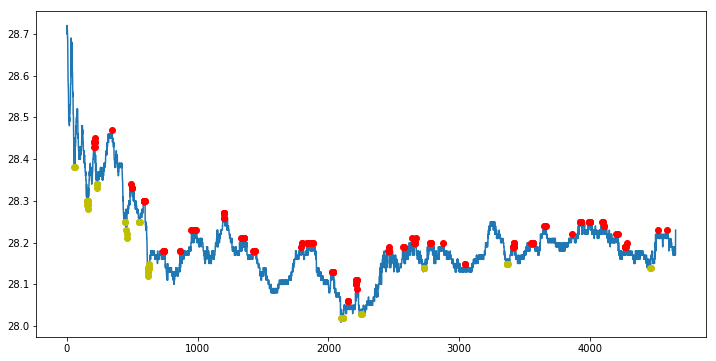

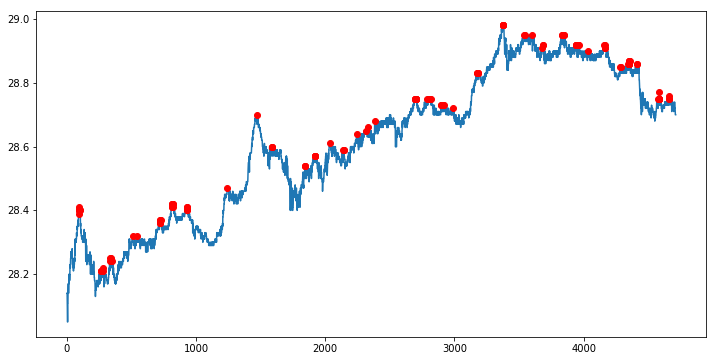

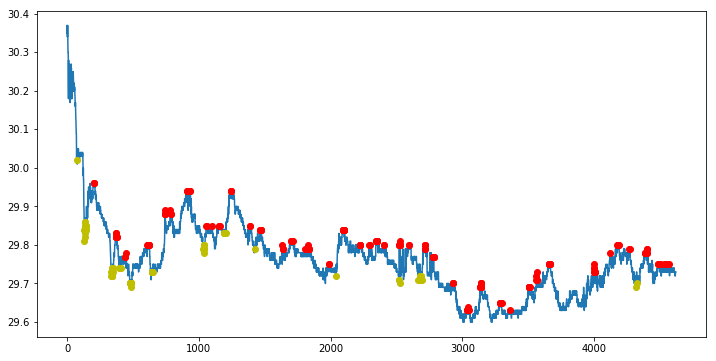

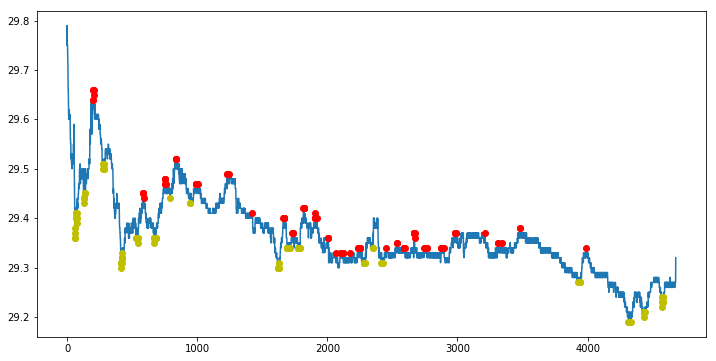

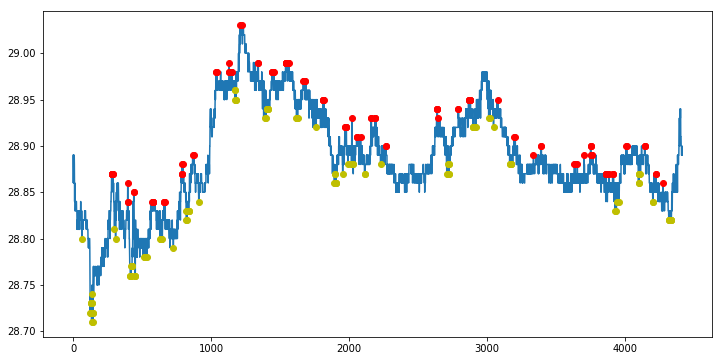

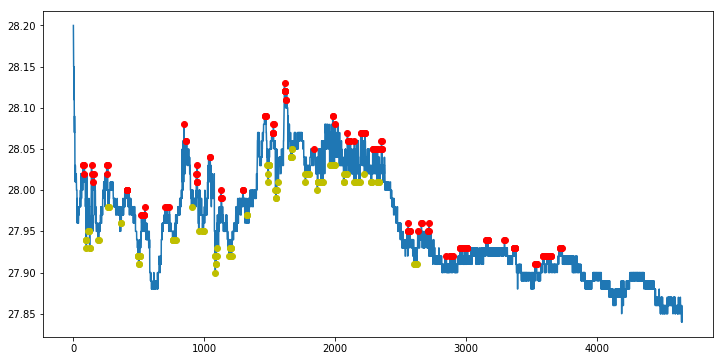

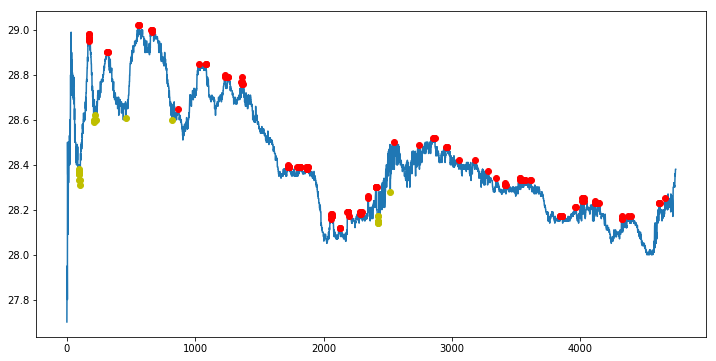

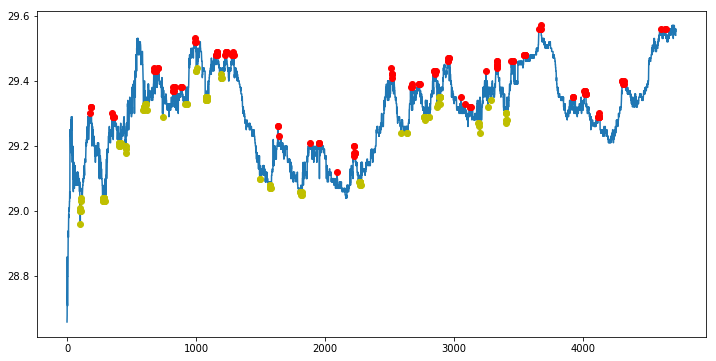

In [5]:
idx = 0

print('total ' + str(len(os.listdir(source_dir))) + ' files.')
for file_name in os.listdir(source_dir):
    idx += 1
    print('current file ' + str(idx) + ': ' + file_name)
    data = pd.read_csv(source_dir + file_name)
    data = data[column_list]
    sell_points = get_sell_points(daily_data = data, windows_size = sell_windows_size, outlier_rate = sell_outlier_rate
                                  ,total_outlier_rate = sell_total_outlier_rate)
    buy_points = get_buy_points(daily_data = data, windows_size = buy_windows_size, outlier_rate = buy_outlier_rate
                                ,total_outlier_rate = buy_total_outlier_rate)
    plot_points(daily_data = data, sell_points = sell_points, buy_points = buy_points, file_name = file_name)
    instances = get_instances(daily_data = data, windows_size = instance_windows_size, sell_points = sell_points
                              ,buy_points = buy_points)
    output_instances(instance_data = instances, file_name = file_name)
    if idx == 1:
        instances_total_set = instances
    else:
        instances_total_set = pd.concat([instances_total_set, instances])
        
output_instances(instance_data = instances_total_set, file_name = '600887_instances_total.csv')